### Libraries

In [23]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import zipfile
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
from shutil import move, rmtree
import random
from itertools import repeat
from collections import Counter
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop, Adam, Adamax
from tensorflow.keras.losses import sparse_categorical_crossentropy, categorical_crossentropy
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras import regularizers, Model
from tensorflow.keras.layers import Dropout
from tensorflow.keras.applications.efficientnet import preprocess_input
from sklearn.metrics import confusion_matrix, classification_report, f1_score, roc_auc_score, recall_score, precision_score
import seaborn as sns
from PIL import Image
import albumentations as A
seed = 1
tf.random.set_seed(
    seed
)
np.random.seed(seed)
from IPython.display import display
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
import warnings
warnings.simplefilter(action='ignore')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Read Data

In [2]:
if os.path.isdir('./Data'):
    rmtree('./Data')
local_zip = '/content/drive/MyDrive/archive.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./Data')
zip_ref.close()

In [3]:
filenames = os.listdir('./Data/dataset/')
print('Classes: ', filenames)
print('The number Classes: ', len(filenames))

Classes:  ['rain', 'dew', 'frost', 'rainbow', 'snow', 'rime', 'sandstorm', 'hail', 'fogsmog', 'lightning', 'glaze']
The number Classes:  11


### EDA

In [4]:
imgnum = []
for file in filenames:
    temp = os.path.join('./Data/dataset/'+file+'/')
    print('The number of Images in {}: {}'.format(file, len(os.listdir(temp))))
    imgnum.append(len(os.listdir(temp)))

The number of Images in rain: 526
The number of Images in dew: 698
The number of Images in frost: 475
The number of Images in rainbow: 232
The number of Images in snow: 621
The number of Images in rime: 1160
The number of Images in sandstorm: 692
The number of Images in hail: 591
The number of Images in fogsmog: 851
The number of Images in lightning: 377
The number of Images in glaze: 639


Text(0.5, 1.0, 'The number of Images per Class')

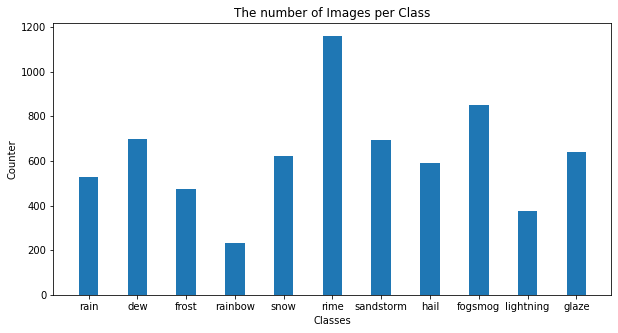

In [5]:
fig = plt.figure(figsize = (10, 5))
plt.bar(filenames, imgnum, width=0.4)
plt.xlabel('Classes')
plt.ylabel('Counter')
plt.title('The number of Images per Class')

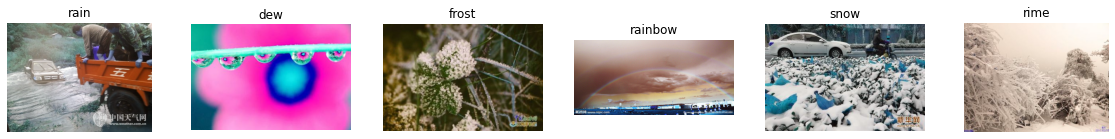

In [6]:
fig, axes = plt.subplots(1, 6)
fig.set_size_inches(20,2)
for ax, file in zip(axes, filenames[:6]):
    temp ='./Data/dataset/'+file+'/'
    sample = cv2.imread(temp+os.listdir(temp)[0], cv2.IMREAD_COLOR)
    ax.imshow(sample)
    ax.axis('off')
    ax.set_title(file)

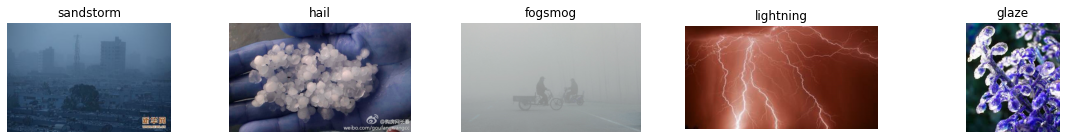

In [7]:
fig, axes = plt.subplots(1, 5)
fig.set_size_inches(20,2)
for ax, file in zip(axes, filenames[6:]):
    temp ='./Data/dataset/'+file+'/'
    sample = cv2.imread(temp+os.listdir(temp)[0], cv2.IMREAD_COLOR)
    ax.imshow(sample)
    ax.axis('off')
    ax.set_title(file)

### Split_Data

In [8]:
def new_dir(path, folder_name):
    diric = str(path)+str(folder_name)+'/'
    if not os.path.exists(diric):
        os.mkdir(diric)
        print(diric + ' is created..!')
        return diric
    else:
        print('Dir is exists .. !')
        return diric
def move_files(filename, dest):
    print(f'Working on file: {filename}')
    if os.path.exists(str(dest)+str(filename)):
        print('The file is exists ...')
    else:
        move(filename, dest)
def split_into_testset(path, path2, folders, perc):
    for folder in folders:
        dir_file_list = []
        temp = os.path.join('./Data/'+path2+'/'+folder+'/')
        img_data = os.listdir(temp)
        for img in img_data:
            org_path = str(temp) + str(img)
            dir_file_list.append(org_path)
        des_file = new_dir(path, folder)
        print(f'The destination path: {des_file}')
        k = int(len(img_data) * perc)
        print(f'The number of moved files: {k}')
        picked_files = random.sample(dir_file_list, k=k)
        for mv in picked_files:
            move_files(mv, des_file)

In [9]:
path ='Data/'
folder_name = {'val_dataset':0.3, 'test_dataset':0.5}
path2  = ['dataset', 'val_dataset']
i=0
for k, v in folder_name.items():
    new_folder_path = new_dir(path, k)
    split_into_testset(new_folder_path, path2[i], filenames, v)
    i+=1

Data/val_dataset/ is created..!
Data/val_dataset/rain/ is created..!
The destination path: Data/val_dataset/rain/
The number of moved files: 157
Working on file: ./Data/dataset/rain/1482.jpg
Working on file: ./Data/dataset/rain/1277.jpg
Working on file: ./Data/dataset/rain/1375.jpg
Working on file: ./Data/dataset/rain/1581.jpg
Working on file: ./Data/dataset/rain/1792.jpg
Working on file: ./Data/dataset/rain/1664.jpg
Working on file: ./Data/dataset/rain/1455.jpg
Working on file: ./Data/dataset/rain/1651.jpg
Working on file: ./Data/dataset/rain/1280.jpg
Working on file: ./Data/dataset/rain/1648.jpg
Working on file: ./Data/dataset/rain/1711.jpg
Working on file: ./Data/dataset/rain/1679.jpg
Working on file: ./Data/dataset/rain/1170.jpg
Working on file: ./Data/dataset/rain/1747.jpg
Working on file: ./Data/dataset/rain/1364.jpg
Working on file: ./Data/dataset/rain/1730.jpg
Working on file: ./Data/dataset/rain/1394.jpg
Working on file: ./Data/dataset/rain/1244.jpg
Working on file: ./Data/dat

In [10]:
train_img = {}
for file in filenames:
    temp = os.path.join('./Data/dataset/'+file+'/')
    print('The number of train Images in {}: {}'.format(file, len(os.listdir(temp))))
    # train_img.append(len(os.listdir(temp)))
    train_img[str(file)] = len(os.listdir(temp))
print(f'\nThe number of all images is: {sum(train_img.values())}')

The number of train Images in rain: 369
The number of train Images in dew: 489
The number of train Images in frost: 333
The number of train Images in rainbow: 163
The number of train Images in snow: 435
The number of train Images in rime: 812
The number of train Images in sandstorm: 485
The number of train Images in hail: 414
The number of train Images in fogsmog: 596
The number of train Images in lightning: 264
The number of train Images in glaze: 448

The number of all images is: 4808


In [11]:
val_img = {}
for file in filenames:
    temp = os.path.join('./Data/val_dataset/'+file+'/')
    print('The number of train Images in {}: {}'.format(file, len(os.listdir(temp))))
    # val_img.append(len(os.listdir(temp)))
    val_img[str(file)] = len(os.listdir(temp))
print(f'\nThe number of all images is: {sum(val_img.values())}')

The number of train Images in rain: 79
The number of train Images in dew: 105
The number of train Images in frost: 71
The number of train Images in rainbow: 35
The number of train Images in snow: 93
The number of train Images in rime: 174
The number of train Images in sandstorm: 104
The number of train Images in hail: 89
The number of train Images in fogsmog: 128
The number of train Images in lightning: 57
The number of train Images in glaze: 96

The number of all images is: 1031


In [12]:
test_img = {}
for file in filenames:
    temp = os.path.join('./Data/test_dataset/'+file+'/')
    print('The number of test Images in {}: {}'.format(file, len(os.listdir(temp))))
    # test_img.append(len(os.listdir(temp)))
    test_img[str(file)] = len(os.listdir(temp))
print(f'\nThe number of all images is: {sum(test_img.values())}')

The number of test Images in rain: 78
The number of test Images in dew: 104
The number of test Images in frost: 71
The number of test Images in rainbow: 34
The number of test Images in snow: 93
The number of test Images in rime: 174
The number of test Images in sandstorm: 103
The number of test Images in hail: 88
The number of test Images in fogsmog: 127
The number of test Images in lightning: 56
The number of test Images in glaze: 95

The number of all images is: 1023


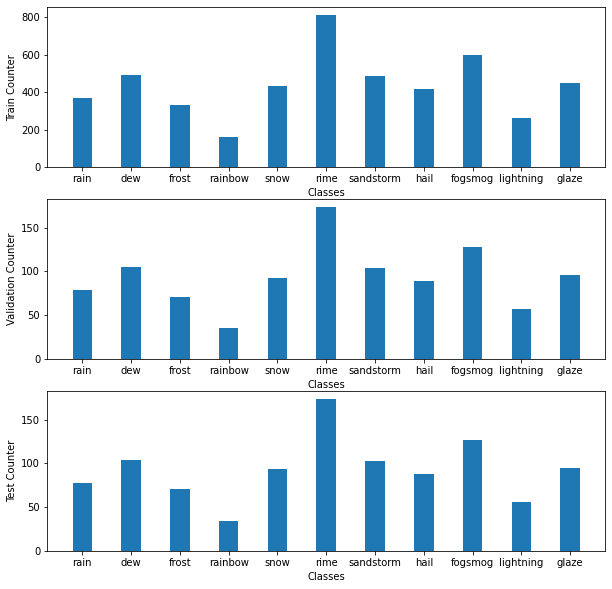

In [13]:
fig, ax = plt.subplots(3, 1)
fig.set_size_inches(10,10)
counter = 0
for s, v in zip(['Train', 'Validation', 'Test'], [train_img.values(), val_img.values(), test_img.values()]):
    ax[counter].bar(filenames, v, width=0.4)
    ax[counter].set_xlabel('Classes')
    ax[counter].set_ylabel(s+' Counter')
    counter+=1

### Image Generator & Augmentation

In [14]:
def aug_data(path, trans, aug):
    for key, val in aug.items():
        temp = os.path.join(str(path)+key+'/')
        imgs = os.listdir(temp)
        if int(val) < 0:
            items = random.sample(imgs, k=abs(val))
            for i in items:
                item = os.path.join(temp, str(i))
                os.remove(item)
        else:
            count = 0
            while count < int(val):
                item = random.choice(imgs)
                item = os.path.join(temp, item)
                img = np.array(Image.open(item))
                transform = trans(image=img)['image']
                try:
                    img_trans = Image.fromarray(transform, 'RGB')
                    img_trans.save(os.path.join(temp, 'a'+str(count)+'.jpg'))
                    count+=1
                except Exception:
                    print('Can\'t Save Photo...')
transformer = A.Compose([
        A.RandomRotate90(),
        A.Flip(),
        A.Transpose(),
        A.OneOf([
            A.IAAAdditiveGaussianNoise(),
            A.GaussNoise(),
        ], p=0.2),
        A.OneOf([
            A.MotionBlur(p=.2),
            A.MedianBlur(blur_limit=3, p=0.1),
            A.Blur(blur_limit=3, p=0.1),
        ], p=0.2),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2),
        A.OneOf([
            A.OpticalDistortion(p=0.3),
            A.GridDistortion(p=.1),
            A.IAAPiecewiseAffine(p=0.3),
        ], p=0.2),
        A.OneOf([
            A.IAASharpen(),
            A.IAAEmboss(),
            A.RandomBrightnessContrast(),            
        ], p=0.3),
    ])
p = './Data/dataset/'
d = {}
for k, v in train_img.items():
    n = 400 - v
    d[k]= n
print(d)
aug_data(p, transformer, d)

{'rain': 31, 'dew': -89, 'frost': 67, 'rainbow': 237, 'snow': -35, 'rime': -412, 'sandstorm': -85, 'hail': -14, 'fogsmog': -196, 'lightning': 136, 'glaze': -48}
Can't Save Photo...
Can't Save Photo...


The number of Images in rain: 400
The number of Images in dew: 400
The number of Images in frost: 400
The number of Images in rainbow: 400
The number of Images in snow: 400
The number of Images in rime: 400
The number of Images in sandstorm: 400
The number of Images in hail: 400
The number of Images in fogsmog: 400
The number of Images in lightning: 400
The number of Images in glaze: 400


Text(0.5, 1.0, 'The number of Images per Class')

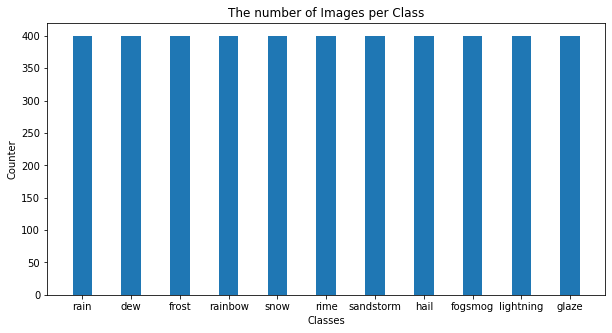

In [15]:
gg = []
for file in filenames:
    temp = os.path.join('./Data/dataset/'+file+'/')
    print('The number of Images in {}: {}'.format(file, len(os.listdir(temp))))
    gg.append(len(os.listdir(temp)))
fig = plt.figure(figsize = (10, 5))
plt.bar(filenames, gg, width=0.4)
plt.xlabel('Classes')
plt.ylabel('Counter')
plt.title('The number of Images per Class')

In [16]:
train_datagen = ImageDataGenerator(
    rescale=1/255,
)
validation_datagen = ImageDataGenerator(
    rescale=1/255,
)
test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
        './Data/dataset/',  
        target_size=(150, 200),  
        batch_size=128,
        class_mode='categorical')
val_generator = validation_datagen.flow_from_directory(
        './Data/val_dataset/',  
        target_size=(150, 200),  
        batch_size=32,
        class_mode='categorical')
test_generator = test_datagen.flow_from_directory(
        './Data/test_dataset/',  
        target_size=(150, 200),  
        batch_size=32,
        class_mode='categorical')

Found 4400 images belonging to 11 classes.
Found 1031 images belonging to 11 classes.
Found 1023 images belonging to 11 classes.


Text(0.5, 1.0, 'Split Data')

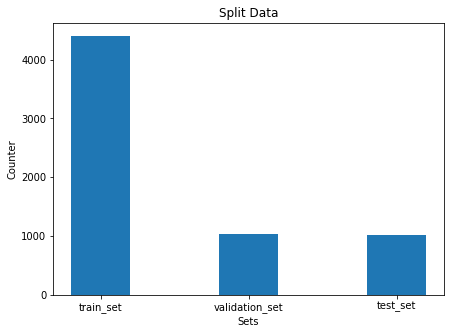

In [17]:
fig = plt.figure(figsize = (7, 5))
plt.bar(['train_set', 'validation_set', 'test_set'], [4400, 1031, 1023], width=0.4)
plt.xlabel('Sets')
plt.ylabel('Counter')
plt.title('Split Data')

### To_DataFrame

In [24]:
def to_dataFrame(gen):
    dic = {'path':[], 'img_name':[], 'category':[], 'labels':[]}
    labels = np.array(gen.labels)
    class_indices = gen.class_indices
    for key in class_indices.keys():
        label = gen.class_indices.get(str(key))
        for path in gen.filepaths:
            chek = path.split('/')
            if key in chek:
                dic['path'].append(path)
                dic['img_name'].append(chek[4])
                # img = Image.open(path)
                # img = np.asarray(img)
                # dic['img'].append(img)
                dic['category'].append(key)
                dic['labels'].append(label)
    return dic

In [25]:
train_df = pd.DataFrame(to_dataFrame(train_generator))
val_df = pd.DataFrame(to_dataFrame(val_generator))
test_df = pd.DataFrame(to_dataFrame(test_generator))
display(train_df.head(5))
display(test_df.head(5))

,path,img_name,category,labels
0,./Data/dataset/dew/2208.jpg,2208.jpg,dew,0
1,./Data/dataset/dew/2209.jpg,2209.jpg,dew,0
2,./Data/dataset/dew/2211.jpg,2211.jpg,dew,0
3,./Data/dataset/dew/2214.jpg,2214.jpg,dew,0
4,./Data/dataset/dew/2215.jpg,2215.jpg,dew,0


,path,img_name,category,labels
0,./Data/test_dataset/dew/2221.jpg,2221.jpg,dew,0
1,./Data/test_dataset/dew/2229.jpg,2229.jpg,dew,0
2,./Data/test_dataset/dew/2231.jpg,2231.jpg,dew,0
3,./Data/test_dataset/dew/2233.jpg,2233.jpg,dew,0
4,./Data/test_dataset/dew/2258.jpg,2258.jpg,dew,0


### CallBack Function

In [19]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_loss') < 0.3) or (logs.get('val_accuracy') >= 0.9):
            print("\nCallback function cancelling training ...!")
            self.model.stop_training = True
callbacks = myCallback()

### CNN Model

In [ ]:
cnn_model = tf.keras.models.Sequential([
    layers.Conv2D(8, (3, 3), activation=tf.nn.relu, input_shape=(150, 200, 3)),
    layers.MaxPool2D(2, 2),
    layers.Conv2D(16, (3, 3), activation=tf.nn.relu),
    layers.MaxPool2D(2, 2),
    layers.Conv2D(64, (3, 3), activation=tf.nn.relu),
    layers.MaxPool2D(2, 2),
    layers.Flatten(),
    layers.Dense(256, activation=tf.nn.relu),
    layers.Dropout(0.15),
    layers.Dense(11, activation=tf.nn.softmax)
])

cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
cnn_history = cnn_model.fit(
    train_generator,
    steps_per_epoch=12,
    # verbose=-1,
    epochs=25,
    validation_data=val_generator,
    validation_steps=12,
    callbacks=[callbacks] )

Epoch 1/25
12/12 [==============================] - 21s 824ms/step - loss: 2.1662 - accuracy: 0.2507 - val_loss: 1.7157 - val_accuracy: 0.4870
Epoch 2/25
12/12 [==============================] - 11s 933ms/step - loss: 1.6267 - accuracy: 0.4440 - val_loss: 1.4390 - val_accuracy: 0.5286
Epoch 3/25
12/12 [==============================] - 10s 851ms/step - loss: 1.3930 - accuracy: 0.5156 - val_loss: 1.3173 - val_accuracy: 0.5469
Epoch 4/25
12/12 [==============================] - 11s 913ms/step - loss: 1.1789 - accuracy: 0.6074 - val_loss: 1.2314 - val_accuracy: 0.5703
Epoch 5/25
12/12 [==============================] - 10s 874ms/step - loss: 1.1319 - accuracy: 0.6217 - val_loss: 1.1464 - val_accuracy: 0.5833
Epoch 6/25
12/12 [==============================] - 11s 944ms/step - loss: 1.0716 - accuracy: 0.6465 - val_loss: 1.0905 - val_accuracy: 0.6042
Epoch 7/25
12/12 [==============================] - 12s 1s/step - loss: 0.9821 - accuracy: 0.6790 - val_loss: 1.0376 - val_accuracy: 0.6432
Ep

In [ ]:
test_loss = cnn_model.evaluate(test_generator)

32/32 [==============================] - 6s 175ms/step - loss: 0.9785 - accuracy: 0.6970


### Xception-Net

In [20]:
x_model = tf.keras.applications.xception.Xception(
    include_top=False,
    weights='imagenet',
)
x = layers.GlobalAveragePooling2D()(x_model.outputs[0])
output = layers.Dense(11, activation='softmax')(x)

xc_model = Model(inputs = x_model.inputs, outputs = output)
xc_model.summary()

83697664/83683744 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 block1_conv1 (Conv2D)          (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, None, None,   128        ['block1_conv1[0][0]']           
 ation)                      

In [21]:
x_model.trainable = False

xc_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics = ['accuracy']
)
xc_history=xc_model.fit(train_generator,  epochs=25, callbacks=[callbacks],  validation_data=val_generator)

Epoch 1/25
35/35 [==============================] - 49s 971ms/step - loss: 1.4939 - accuracy: 0.5623 - val_loss: 0.9881 - val_accuracy: 0.7158
Epoch 2/25
35/35 [==============================] - 31s 892ms/step - loss: 0.8288 - accuracy: 0.7573 - val_loss: 0.7894 - val_accuracy: 0.7507
Epoch 3/25
35/35 [==============================] - 33s 928ms/step - loss: 0.6729 - accuracy: 0.7934 - val_loss: 0.7088 - val_accuracy: 0.7847
Epoch 4/25
35/35 [==============================] - 32s 926ms/step - loss: 0.5911 - accuracy: 0.8223 - val_loss: 0.6705 - val_accuracy: 0.7837
Epoch 5/25
35/35 [==============================] - 32s 902ms/step - loss: 0.5299 - accuracy: 0.8402 - val_loss: 0.6346 - val_accuracy: 0.7983
Epoch 6/25
35/35 [==============================] - 32s 910ms/step - loss: 0.4849 - accuracy: 0.8550 - val_loss: 0.6113 - val_accuracy: 0.8118
Epoch 7/25
35/35 [==============================] - 33s 954ms/step - loss: 0.4474 - accuracy: 0.8693 - val_loss: 0.5959 - val_accuracy: 0.8089

In [22]:
xception_test = xc_model.evaluate(test_generator)

32/32 [==============================] - 7s 220ms/step - loss: 0.5759 - accuracy: 0.8006


### MobileNet

In [29]:
m_model = tf.keras.applications.MobileNet(
    include_top=False,
    weights='imagenet',
)
x = layers.GlobalAveragePooling2D()(m_model.outputs[0])
x = Dropout(0.1)(x)
output = layers.Dense(11, activation='softmax')(x)

mo_model = Model(inputs = m_model.inputs, outputs = output)
mo_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 conv1 (Conv2D)              (None, None, None, 32)    864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, None, None, 32)   128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, None, None, 32)    0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, None, None, 32)   288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, None, None, 32)   128       
 ation)                                                    

In [30]:
m_model.trainable = False

mo_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics = ['accuracy']
)
mo_history=mo_model.fit(train_generator,  epochs=25, callbacks=[callbacks],  validation_data=val_generator)

Epoch 1/25
35/35 [==============================] - 32s 874ms/step - loss: 1.8812 - accuracy: 0.4123 - val_loss: 0.9898 - val_accuracy: 0.6634
Epoch 2/25
35/35 [==============================] - 29s 811ms/step - loss: 0.8622 - accuracy: 0.7109 - val_loss: 0.7197 - val_accuracy: 0.7478
Epoch 3/25
35/35 [==============================] - 29s 825ms/step - loss: 0.6557 - accuracy: 0.7780 - val_loss: 0.6102 - val_accuracy: 0.7915
Epoch 4/25
35/35 [==============================] - 28s 802ms/step - loss: 0.5466 - accuracy: 0.8125 - val_loss: 0.5543 - val_accuracy: 0.8050
Epoch 5/25
35/35 [==============================] - 30s 841ms/step - loss: 0.4808 - accuracy: 0.8350 - val_loss: 0.5282 - val_accuracy: 0.8089
Epoch 6/25
35/35 [==============================] - 28s 802ms/step - loss: 0.4334 - accuracy: 0.8541 - val_loss: 0.4946 - val_accuracy: 0.8235
Epoch 7/25
35/35 [==============================] - 28s 812ms/step - loss: 0.4127 - accuracy: 0.8595 - val_loss: 0.5015 - val_accuracy: 0.8099

In [31]:
mobile_test = mo_model.evaluate(test_generator)

32/32 [==============================] - 6s 190ms/step - loss: 0.4223 - accuracy: 0.8524


### DenseNet201

In [ ]:
D_model = tf.keras.applications.DenseNet201(
    include_top=False,
    weights='imagenet',
)
x = layers.GlobalAveragePooling2D()(D_model.outputs[0])
output = layers.Dense(11, activation='softmax')(x)

de_model = Model(inputs = D_model.inputs, outputs = output)
de_model.summary()

74850304/74836368 [==============================] - 1s 0us/step
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, None, None,   0          ['input_3[0][0]']                
                                3)                                                                
                                                                                                  
 conv1/conv (Conv2D)            (None, None, None,   9408        ['zero_padding2d[0][0]']         
                           

In [ ]:
D_model.trainable = False

de_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics = ['accuracy']
)
de_history=de_model.fit(train_generator,  epochs=25, callbacks=[callbacks],  validation_data=val_generator)

Epoch 1/25
35/35 [==============================] - 56s 1s/step - loss: 1.5174 - accuracy: 0.5120 - val_loss: 0.8840 - val_accuracy: 0.7498
Epoch 2/25
35/35 [==============================] - 32s 917ms/step - loss: 0.7320 - accuracy: 0.7791 - val_loss: 0.6765 - val_accuracy: 0.7992
Epoch 3/25
35/35 [==============================] - 31s 916ms/step - loss: 0.5604 - accuracy: 0.8336 - val_loss: 0.5690 - val_accuracy: 0.8186
Epoch 4/25
35/35 [==============================] - 31s 892ms/step - loss: 0.4778 - accuracy: 0.8570 - val_loss: 0.5386 - val_accuracy: 0.8196
Epoch 5/25
35/35 [==============================] - 33s 931ms/step - loss: 0.4211 - accuracy: 0.8732 - val_loss: 0.5016 - val_accuracy: 0.8390
Epoch 6/25
35/35 [==============================] - 31s 898ms/step - loss: 0.3822 - accuracy: 0.8877 - val_loss: 0.4731 - val_accuracy: 0.8487
Epoch 7/25
35/35 [==============================] - 31s 883ms/step - loss: 0.3506 - accuracy: 0.8961 - val_loss: 0.4578 - val_accuracy: 0.8477
Ep

In [ ]:
dense_test = de_model.evaluate(test_generator)

32/32 [==============================] - 9s 277ms/step - loss: 0.4328 - accuracy: 0.8583


### Error Analysis

Text(0, 0.5, 'Loss')

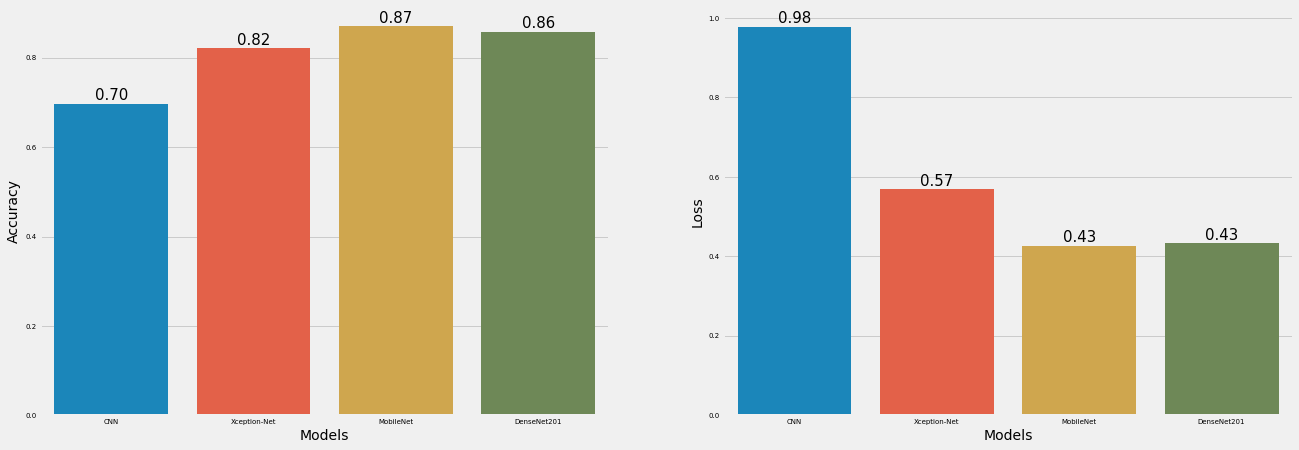

In [ ]:
output = pd.DataFrame({'name':['CNN', 'Xception-Net', 'MobileNet', 'DenseNet201'],
          'Loss':[test_loss[0], xception_test[0], mobile_test[0], dense_test[0]],
          'Accuracy':[test_loss[1], xception_test[1], mobile_test[1], dense_test[1]]
          })

fig, ax = plt.subplots(1, 2, figsize=(20, 7))
plots = sns.barplot(x='name', y='Accuracy', data=output, ax=ax[0])
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),
                  (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                  size=15, xytext=(0, 8),
                  textcoords='offset points')

ax[0].set_xlabel("Models", size=14)
ax[0].set_ylabel("Accuracy", size=14)

plots = sns.barplot(x='name', y='Loss', data=output, ax=ax[1])
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),
                  (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                  size=15, xytext=(0, 8),
                  textcoords='offset points')

ax[1].set_xlabel("Models", size=14)
ax[1].set_ylabel("Loss", size=14)


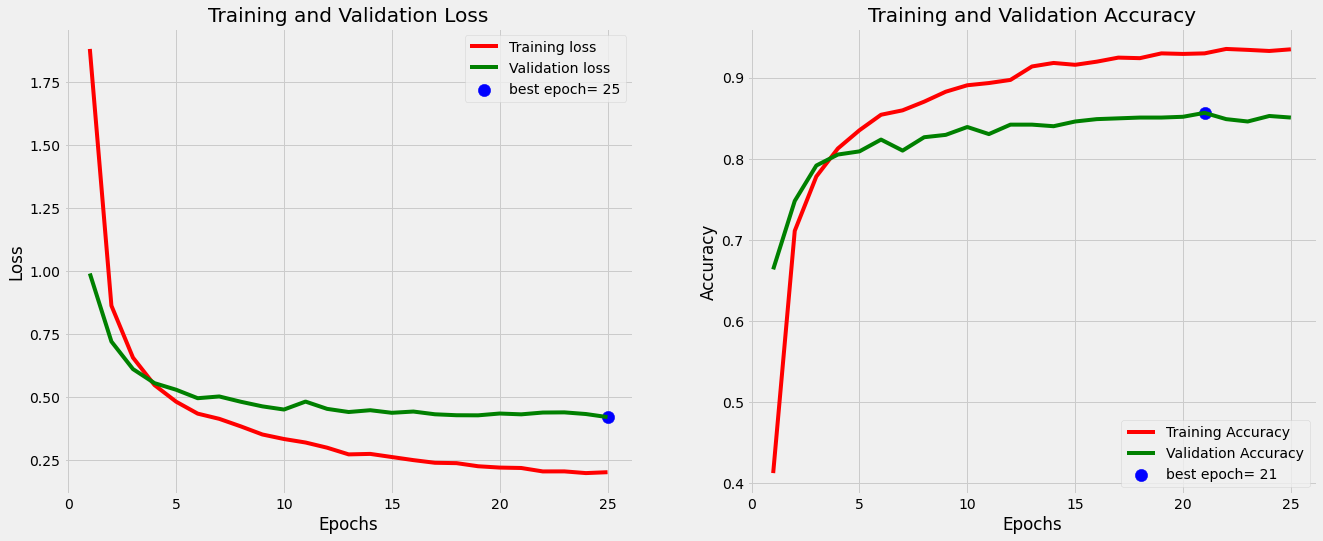

In [32]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    plt.show()
tr_plot(mo_history,0)

In [50]:
def classi_repo(train_gen, pred, model, model_name='Classifier'):
    pred = np.argmax(pred,axis=1)
    labels = (train_gen.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    pred = [labels[k] for k in pred]
    classes = list(train_gen.class_indices.keys())
    length = len(classes)
    valid_target = test_df.category
    print(model_name+':')
    print('F1-Score: ', f1_score(valid_target, pred, average='weighted'))
    # print('ROC_AUC_score: ', roc_auc_score(valid_target, pred), '\n\n')
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,5))
    clf_report = classification_report(valid_target,
                                   pred,
                                   output_dict=True)
    g = sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True, cmap='Blues', ax=ax1)
    g.set_title('Classification Report\n\n');
    #=========================================
    cf_matrix = confusion_matrix(valid_target, pred)
    g1 = sns.heatmap(cf_matrix, annot=True, cmap='Blues',ax=ax2)
    g1.set_title('Confusion Matrix\n\n');
    g1.set_xlabel('\nPredicted Values')
    g1.set_ylabel('Actual Values ');
    plt.xticks(np.arange(length)+.5, classes, rotation= 90)
    plt.yticks(np.arange(length)+.5, classes, rotation=0)
    
    plt.show()

In [46]:
def print_info( test_gen, preds, print_code, subject ):
    class_dict=test_gen.class_indices
    labels= test_gen.labels
    file_names= test_gen.filenames 
    error_list=[]
    true_class=[]
    pred_class=[]
    prob_list=[]
    new_dict={}
    error_indices=[]
    y_pred=[]
    for key,value in class_dict.items():
        new_dict[value]=key
    classes=list(new_dict.values())
    errors=0      
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)         
        true_index=labels[i]
        if pred_index != true_index:
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)            
            errors=errors + 1
        y_pred.append(pred_index)    
    if print_code !=0:
        if errors>0:
            if print_code>errors:
                r=errors
            else:
                r=print_code           
            msg='{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format('Filename', 'Predicted Class' , 'True Class', 'Probability')
            print_in_color(msg, (0,255,0),(55,65,80))
            for i in range(r):                
                split1=os.path.split(error_list[i])                
                split2=os.path.split(split1[0])                
                fname=split2[1] + '/' + split1[1]
                msg='{0:^28s}{1:^28s}{2:^28s}{3:4s}{4:^6.4f}'.format(fname, pred_class[i],true_class[i], ' ', prob_list[i])
                print_in_color(msg, (255,255,255), (55,65,60))
                #print(error_list[i]  , pred_class[i], true_class[i], prob_list[i])               
        else:
            msg='With accuracy of 100 % there are no errors to print'
            print_in_color(msg, (0,255,0),(55,65,80))
    if errors>0:
        plot_bar=[]
        plot_class=[]
        for  key, value in new_dict.items():        
            count=error_indices.count(key) 
            if count!=0:
                plot_bar.append(count) # list containg how many times a class c had an error
                plot_class.append(value)   # stores the class 
        fig=plt.figure()
        fig.set_figheight(len(plot_class)/3)
        fig.set_figwidth(10)
        plt.style.use('fivethirtyeight')
        for i in range(0, len(plot_class)):
            c=plot_class[i]
            x=plot_bar[i]
            plt.barh(c, x, )
            plt.title( ' Errors by Class on Test Set')
    y_true= np.array(labels)        
    y_pred=np.array(y_pred)

Mobile_Net:
F1-Score:  0.10119394497769328


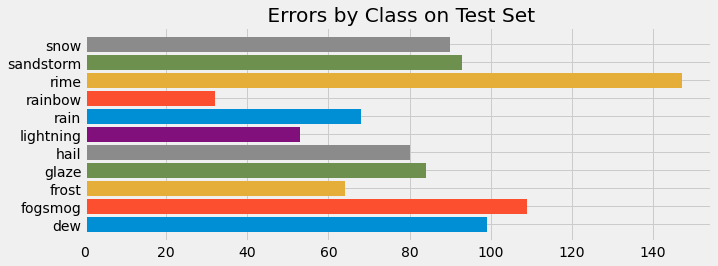

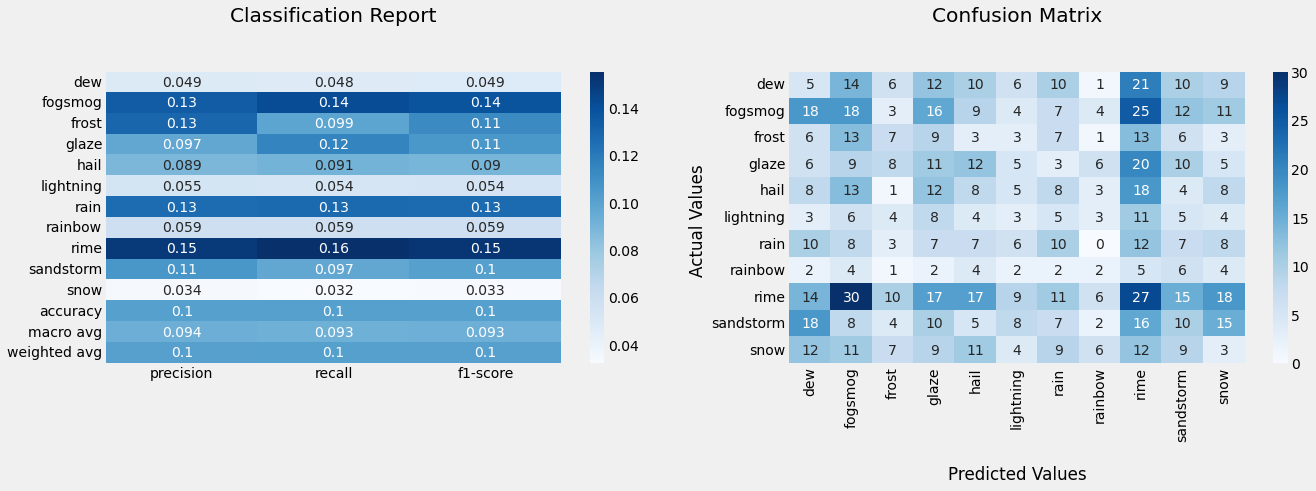

In [54]:
pred=mo_model.predict(test_generator, steps=32)
print_info( test_generator, pred, 0, 'Weather' )
classi_repo(train_generator, pred, mo_model, 'Mobile_Net')

The number of Images that miss labeled: 914


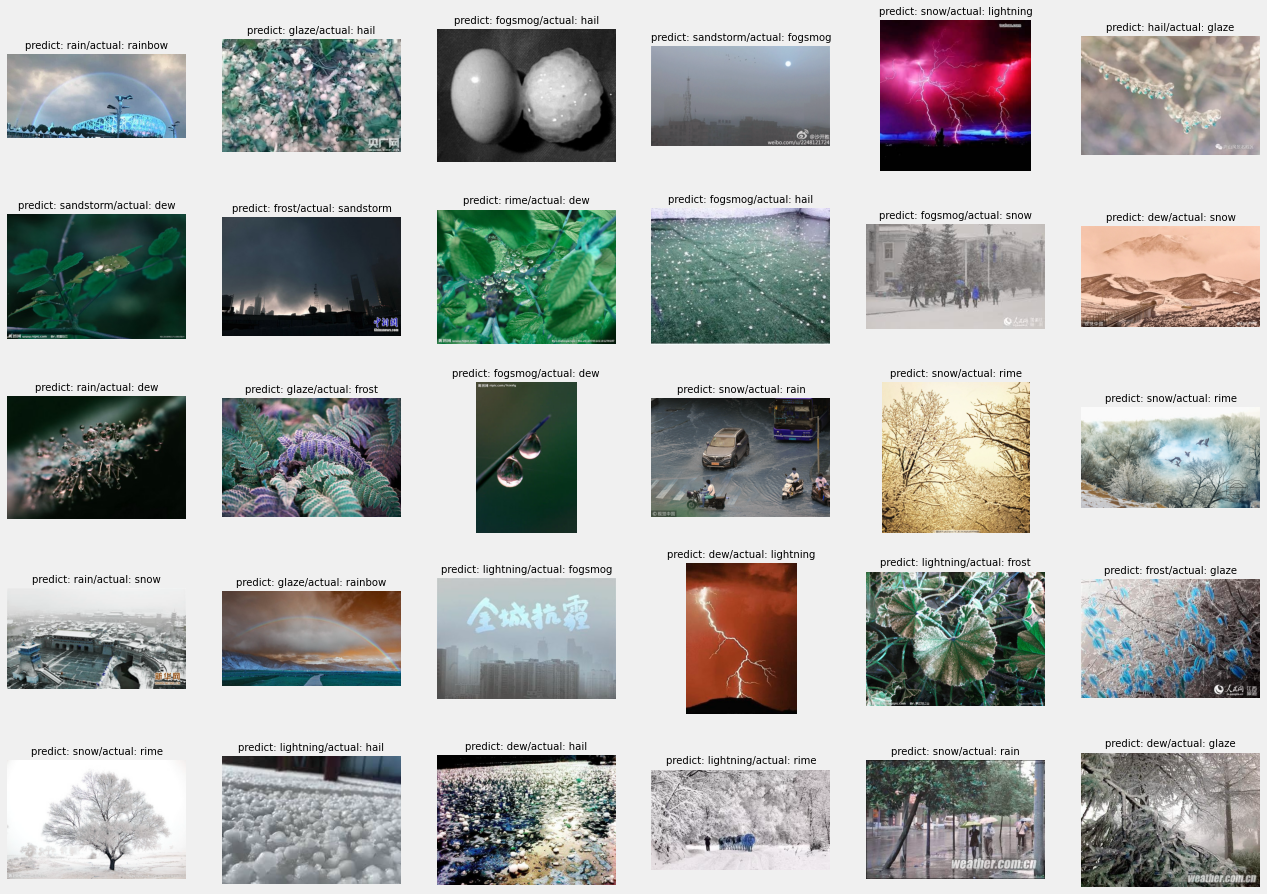

In [52]:
def miss_labeled(preds, gen):
    class_dict=gen.class_indices
    labels= gen.labels
    file_names= gen.filepaths
    new_dict={}
    for key,value in class_dict.items():
        new_dict[value]=key
    classes=list(new_dict.values()) 
    missing = {'img_path':[], 'predicted':[], 'actual':[]}
    for i, p in enumerate(preds):
            pred_index=np.argmax(p)
            true_index=labels[i]
            if pred_index != true_index:
                missing['img_path'].append(file_names[i])
                missing['actual'].append(new_dict[true_index])
                missing['predicted'].append(new_dict[pred_index])
    length = len(missing['img_path'])
    print(f'The number of Images that miss labeled: {length}')
    # print()
    # for k in Counter(missing['actual']).most_common(11):
    #     print(f'The number of miss labeled {list(k)[0]} Images is: {list(k)[1]}')
    df = pd.DataFrame(missing)
    x = np.array(random.sample(list(df.index), k=30)).reshape(5, 6)
    fig, ax = plt.subplots(5,6, figsize=(20,15))
    plt.rcParams.update({'font.size': 7})
    cont = 0
    for pic in range(5):
        for cont in range(6):
            value = x[pic][cont]
            pth = df.iloc[value]['img_path']
            pre = df.iloc[value]['predicted']
            act = df.iloc[value]['actual']
            sample = cv2.imread(pth, cv2.IMREAD_COLOR)
            ax[pic, cont].imshow(sample)
            ax[pic, cont].axis('off')
            ax[pic, cont].set_title('predict: '+str(pre)+'/'+'actual: '+str(act))
miss_labeled(pred, test_generator)